In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
import math

# Question

The goal of our predictive question is to determine the farthest horizontal distance that a child of given mass (40 kg) can jump off of a swinging swingset. This is an interesting question to explore, as almost anybody who chooses to jump off of a swinging swingset will want to travel the maximum distance possible for maximum fun. So, we will be able to explore that maximum distance for a 40kg child.

# Model

We will implement our model by creating a system to execute a sweep of different angles that will give us varying displacements in the x direction to ultimately find the optimal (maximum) distance.

We are neglecting any drag force and frictional force on the seat. In the real world, these forces (particularly air resistance) will play a role when calculating the velocity of the swing, for example, but for the sake of simplicity, we will exclude these external forces. This may result in less accurate results, but we estimate the results to be in the range of reasonable values.

Our parameters include the acceleration due to gravity (9.8 m/s^2), mass of child (40 kg), mass of swing (5 kg, chain mass negligible), length of chain (2.5 m), initial angle (225 degrees), initial angular velocity (0 radians/s, no initial push), and time duration of the pendulum simulation (15 s).

In [3]:
# Here are the units we'll need:

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter
joule = UNITS.joule
degree = UNITS.degree;

Stage 1: Swing is a pendulum

In [4]:
#Params Start

g = 9.8*m/s**2
ChildMass = 40*kg
SwingMass = 5*kg
StringLength = 2.5*m
AngleInit = -(math.pi)/3
aVelocityInit = 0/s
t_end = 2*s;


In [5]:
#Setting params

params = Params(g = g,
                ChildMass = ChildMass,
                SwingMass = SwingMass,
                StringLength = StringLength,
                AngleInit = AngleInit,
                t_end = t_end,
                aVelocityInit = aVelocityInit)

g                9.8 meter / second ** 2
ChildMass                    40 kilogram
SwingMass                     5 kilogram
StringLength                   2.5 meter
AngleInit                        -1.0472
t_end                           2 second
aVelocityInit                 0 / second
dtype: object

In [6]:
def make_system(params):

    init = State(angle = params.AngleInit, av = params.aVelocityInit)

    Child = params.ChildMass
    r = params.StringLength
    Seat = params.SwingMass
    g = params.g
    t_end = params.t_end
    dt = t_end/100

    return System(init=init, Child=Child, r=r, Seat=Seat, g=g, t_end=t_end, dt=dt)


In [7]:
def slope_func(state, t, system):
    """
    Computes derivatives of the state variables.

        state: angle, angular velocity
        t: time (unused)
        system: System object (unused)

    returns: derivatives of angle & velocity
    """
    angle, av = state
    unpack(system)

    dadt = av
    davdt = -(system.g*math.sin(angle))/system.r

    return dadt, davdt

In [8]:
pendulum = make_system(params)

init     angle       -1.0472
av       0 / second
dtype:...
Child                                          40 kilogram
r                                                2.5 meter
Seat                                            5 kilogram
g                                  9.8 meter / second ** 2
t_end                                             2 second
dt                                             0.02 second
dtype: object

In [9]:
slope_func(pendulum.init, 0, pendulum)

(0 <Unit('1 / second')>, 3.3948195828349994 <Unit('1 / second ** 2')>)

In [10]:
# solves differential equation

results, details = run_ode_solver(pendulum, slope_func)
results

angle                            av
0.00                            -1.0472                    0 / second
0.02  -1.0465185872800307 dimensionless  0.06789639165669999 / second
0.04  -1.0444819618406629 dimensionless    0.135739484746347 / second
0.06   -1.041089275242371 dimensionless  0.20347563188653522 / second
0.08  -1.0363432057837414 dimensionless  0.27105052250649103 / second
...                                 ...                           ...
1.92   0.9675624815849634 dimensionless  -0.7265347787380169 / second
1.94   0.9523861578266541 dimensionless  -0.7907721893986798 / second
1.96   0.9359319099171372 dimensionless  -0.8542905261401317 / second
1.98   0.9182148601370111 dimensionless  -0.9170141735552312 / second
2.00   0.8992516738645995 dimensionless  -0.9788644043599725 / second

[101 rows x 2 columns]

In [11]:
# Converts radians to degrees

rad = (180/math.pi) * degree

57.29577951308232 <Unit('degree')>

# Results

Our model generated a plot of the swing angle vs. time as well as angular velocity vs. time. This graph below shows a good confirmation that we have a model that matches up with the physics of a pendulum. This is because you can see in the graph that when the angle is at 0 the angular velocity is at it highest vs. when the angle is at is highest the av is at zero. This matches up well with what pendulums actually do. We put all of these into a sweep series and used this in the second part of the model. We took each angle and its corresponding av and input them into our projectile model to find the maximum horizontal displacement, which is what we will ultimately be recording to answer our question.

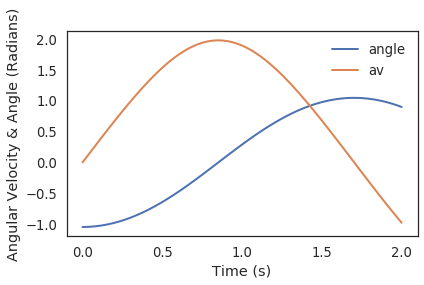

In [26]:
# takes into account pendulum angle in relation to time

plot(results.angle, label='angle')

decorate(xlabel='Time (s)',
         ylabel='Angle of the pendulum (degrees)')

plot(results.av, label='av')

decorate(xlabel='Time (s)',
         ylabel='Angular Velocity & Angle (Radians)')

# Stage 2: Kid is yoted off swing

In [13]:
t_end = 20 * s
dt = t_end / 100

params = Params(x = 0 * m, 
                y = 1 * m,
                g = 9.8 * m/s**2,
                mass = 40 * kg,
                angle = 45 * degree,
                velocity = 40 * m / s,
                t_end=t_end,
                dt=dt,
                r = 2.5*m)

x                           0 meter
y                           1 meter
g           9.8 meter / second ** 2
mass                    40 kilogram
angle                     45 degree
velocity        40.0 meter / second
t_end                     20 second
dt                       0.2 second
r                         2.5 meter
dtype: object

In [14]:
def make_system_2(params):
    """
    Makes a system object.
    
    params: Params object with angle, velocity, x, y, duration, g,
               
    returns: System object
    """
    angle, velocity = params.angle, params.velocity
    
    # convert angle to degrees
    theta = angle
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    R = Vector(params.x, params.y)
    V = Vector(vx, vy)
    init = State(R=R, V=V)
    r=params.r
    
    return System(params, init=init)

In [15]:
def slope_func(state, t, system):
    """
    Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with mass & g

    returns: sequence (vx, vy, ax, ay)
    """
    R, V = state
    mass, g = system.mass, system.g
    
    a_grav = Vector(0, -g)
    A = a_grav
    
    return V, A

In [16]:
def event_func(state, t, system):
    """
    Stops when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    R, V = state
    return R.y

In [17]:
yeet = make_system_2(params)
Results, details = run_ode_solver(yeet, slope_func, events=event_func)
details

success                             True
message    A termination event occurred.
dtype: object

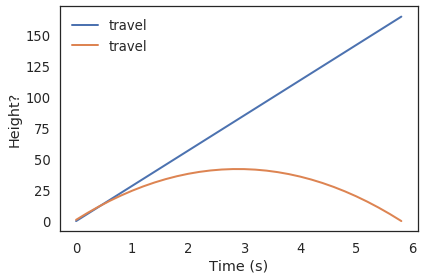

In [18]:
plot(Results.R, label='travel')

decorate(xlabel='Time (s)',
         ylabel='Height?')

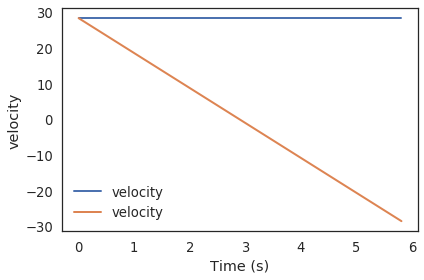

In [19]:
plot(Results.V, label='velocity')

decorate(xlabel='Time (s)',
         ylabel='velocity')

In [20]:
def range_func(angle, av, params):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: distance in meters
    """
    #print(angle, av)
    velocity = av*params.r
    params = Params(params, angle=angle, velocity=velocity)
    system = make_system_2(params)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    x_dist = get_last_value(results.R).x
    #print(angle, x_dist)
    return x_dist

In [21]:
print (results)

                                  angle                            av
0.00                            -1.0472                    0 / second
0.02  -1.0465185872800307 dimensionless  0.06789639165669999 / second
0.04  -1.0444819618406629 dimensionless    0.135739484746347 / second
0.06   -1.041089275242371 dimensionless  0.20347563188653522 / second
0.08  -1.0363432057837414 dimensionless  0.27105052250649103 / second
...                                 ...                           ...
1.92   0.9675624815849634 dimensionless  -0.7265347787380169 / second
1.94   0.9523861578266541 dimensionless  -0.7907721893986798 / second
1.96   0.9359319099171372 dimensionless  -0.8542905261401317 / second
1.98   0.9182148601370111 dimensionless  -0.9170141735552312 / second
2.00   0.8992516738645995 dimensionless  -0.9788644043599725 / second

[101 rows x 2 columns]


In [22]:
## From Jason:

sweep = SweepSeries()

for angle, av in zip(results.angle, results.av):
    #print(angle, av)
    x_dist = range_func(angle, av, params)
    sweep[angle*rad] = x_dist
print(sweep)

-60.000000                     0.0 meter
-59.961098     0.03663511721240593 meter
-59.844408     0.07142623517042877 meter
-59.650022     0.10475769646538338 meter
-59.378092     0.13637497223104694 meter
                         ...            
 55.437247    -0.32336023439252354 meter
 54.567707    -0.35057102418493824 meter
 53.624948    -0.37839238532743386 meter
 52.609836    -0.40698170414764057 meter
 51.523326      -0.436484920391761 meter
Length: 101, dtype: object


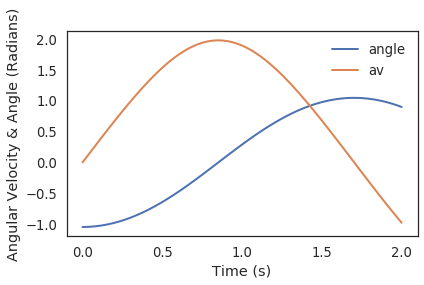

In [23]:
plot(results.angle, label='angle')

decorate(xlabel='Time (s)',
         ylabel='Angle of the pendulum (degrees)')
plot(results.av, label='av')

decorate(xlabel='Time (s)',
         ylabel='Angular Velocity & Angle (Radians)')

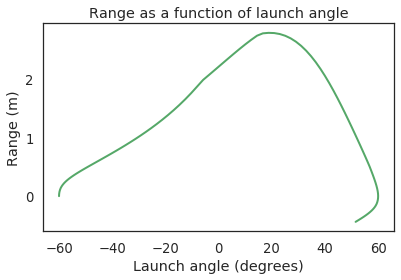

In [24]:
plot(sweep, color='C2')
decorate(xlabel='Launch angle (degrees)',
         ylabel='Range (m)',
         title='Range as a function of launch angle',
         legend=False)

In [25]:
g = sweep.max()
sweep[sweep == g]

18.793648    2.773540707930243 meter
dtype: object

# Interpretation

After implementing our sweep, the graph of Range vs. Launch angle shows that the maximum horizontal distance that the child travels after jumping off the swing is between 2.5-3 m, and occurs at an angle of 20 degrees. This makes sense, given that a smaller launch angle will result in a greater horizontal displacement. Also, it seems reasonable to think that a 40kg child will land 3 meters away from the swing, but whether that would be the maximum distance might be up for debate.
A limitation of our model lies in the fact that we only accounted for one mass of a child (40 kg), so these particular results would only apply to a child of said mass. In addition, we neglected air resistance and friction caused by the seat of the swing, leading to slight deviations from realistic environments.